In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D,
    Dense, Dropout, BatchNormalization,SpatialDropout1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import joblib, os, random, string

In [ ]:
MAX_LEN = 40
EPOCHS = 30
BATCH_SIZE = 512
SEED = 42
os.makedirs("artifacts", exist_ok=True)


np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/final_language_dataset.csv")

# Ensure we only keep non-null entries
df = df.dropna(subset=["ASCII", "label"])
df["ASCII"] = df["ASCII"].astype(str).str.strip()

print(df["label"].value_counts())

label
0    368176
1    228482
Name: count, dtype: int64


In [ ]:
def generate_junk_word():
    letters = string.ascii_lowercase
    length = random.randint(3, 20)
    return ''.join(random.choices(letters, k=length))

def introduce_typos(word):
    """Create typos to distort real words"""
    word = list(word)
    for _ in range(random.randint(1, 2)):
        action = random.choice(["insert", "delete", "swap", "replace"])
        idx = random.randint(0, len(word)-1)
        if action == "insert":
            word.insert(idx, random.choice(string.ascii_lowercase))
        elif action == "delete" and len(word) > 3:
            del word[idx]
        elif action == "swap" and idx < len(word)-1:
            word[idx], word[idx+1] = word[idx+1], word[idx]
        elif action == "replace":
            word[idx] = random.choice(string.ascii_lowercase)
    return ''.join(word)

# OCR-like distortions for realism
def introduce_ocr_noise(word):
    swaps = {'a':'o', 'i':'l', 's':'f', 'c':'e', 'n':'m', 'r':'n', 'u':'v', 'h':'b'}
    w = list(word)
    for _ in range(random.randint(1, 2)):
        idx = random.randint(0, len(w)-1)
        if w[idx] in swaps:
            w[idx] = swaps[w[idx]]
    return ''.join(w)

# Combine random + typo + OCR noise
random_junk = [generate_junk_word() for _ in range(40000)]
typo_junk = [introduce_typos(generate_junk_word()) for _ in range(30000)]
ocr_junk = [introduce_ocr_noise(generate_junk_word()) for _ in range(30000)]

junk_words = random_junk + typo_junk + ocr_junk

junk_df = pd.DataFrame({
    "ASCII": junk_words,
    "label": [2] * len(junk_words)
})

print(f" Generated {len(junk_df)} junk/gibberish samples")

✅ Generated 100000 junk/gibberish samples


In [ ]:
def generate_noisy_sanskrit(df, num_samples=20000):
    sanskrit_words = df[df["label"] == 1]["ASCII"].sample(num_samples//2, random_state=42)
    noisy_words = []
    for w in sanskrit_words:
        w = list(w)
        for _ in range(random.randint(1, 2)):
            action = random.choice(["swap", "substitute", "drop"])
            idx = random.randint(0, len(w)-1)
            if action == "swap" and idx < len(w)-1:
                w[idx], w[idx+1] = w[idx+1], w[idx]
            elif action == "substitute":
                w[idx] = random.choice(string.ascii_lowercase)
            elif action == "drop" and len(w) > 4:
                w.pop(idx)
        noisy_words.append(''.join(w))
    return noisy_words

noisy_sanskrit = generate_noisy_sanskrit(df, num_samples=20000)

noisy_sanskrit_df = pd.DataFrame({
    "ASCII": noisy_sanskrit,
    "label": [1] * len(noisy_sanskrit)
})

print(f" Generated {len(noisy_sanskrit_df)} noisy Sanskrit samples")

augmented_df = pd.concat([df, junk_df, noisy_sanskrit_df], ignore_index=True)
augmented_df = augmented_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

print(f" Final dataset: {len(augmented_df)} samples")
print(augmented_df["label"].value_counts())


✅ Generated 10000 noisy Sanskrit samples
📊 Final dataset: 706658 samples
label
0    368176
1    238482
2    100000
Name: count, dtype: int64


In [ ]:
tokenizer = Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(augmented_df["ASCII"])

VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f"📏 Vocab size: {VOCAB_SIZE}")

def encode_texts(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=MAX_LEN, padding="post")

X = encode_texts(augmented_df["ASCII"])
y = augmented_df["label"].values

📏 Vocab size: 44


In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")




Train: 494660 | Val: 105999 | Test: 105999


In [ ]:
def build_charcnn(vocab_size, maxlen):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=maxlen),
        SpatialDropout1D(0.2),
        Conv1D(256, 7, activation="relu", padding="same"),
        Dropout(0.3),
        MaxPooling1D(2),
        Conv1D(256, 5, activation="relu", padding="same"),
        Dropout(0.3),
        MaxPooling1D(2),
        Conv1D(256, 3, activation="relu", padding="same"),
        GlobalMaxPooling1D(),
        Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(3, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_charcnn(VOCAB_SIZE, MAX_LEN)

model.summary()

callbacks = [
    EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    ModelCheckpoint("artifacts/best_charcnn_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    tf.keras.callbacks.CSVLogger("artifacts/training_log.csv", append=False)
]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def make_ds(X, y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(buffer_size=50000, seed=SEED)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train)
val_ds = make_ds(X_val, y_val, training=False)
test_ds = make_ds(X_test, y_test, training=False)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

loss, acc = model.evaluate(test_ds)
print(f"\n Test Accuracy: {acc:.4f}")

Epoch 1/30
967/967 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.9357 - loss: 0.1859 - val_accuracy: 0.9732 - val_loss: 0.0798 - learning_rate: 0.0010
Epoch 2/30
967/967 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.9694 - loss: 0.0889 - val_accuracy: 0.9748 - val_loss: 0.0728 - learning_rate: 0.0010
Epoch 3/30
967/967 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.9722 - loss: 0.0768 - val_accuracy: 0.9768 - val_loss: 0.0644 - learning_rate: 0.0010
Epoch 4/30
967/967 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.9744 - loss: 0.0711 - val_accuracy: 0.9776 - val_loss: 0.0615 - learning_rate: 0.0010
Epoch 5/30
967/967 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.9757 - loss: 0.0676 - val_accuracy: 0.9790 - val_loss: 0.0593 - learning_rate: 0.0010
Epoch 6/30
967/967 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.9765 - loss: 0.0649 - val_accuracy: 0.9793 - val_loss: 0.0586 - learning_rate: 0.0010
Epoch 7/30
967/967 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.9776 - l

In [ ]:
joblib.dump(tokenizer, "artifacts/tokenizer.pkl")
joblib.dump(label_encoder, "artifacts/label_encoder.pkl")
print(" Tokenizer & Label Encoder saved")

# Wrap everything in one pipeline dict
pipeline = {
    "model_path": "artifacts/best_charcnn_model.keras",
    "tokenizer_path": "artifacts/tokenizer.pkl",
    "label_encoder_path": "artifacts/label_encoder.pkl",
    "max_len": MAX_LEN
}


joblib.dump(pipeline, "artifacts/charcnn_pipeline.pkl")
print(" Unified pipeline saved: artifacts/charcnn_pipeline.pkl")


✅ Tokenizer & Label Encoder saved
✅ Unified pipeline saved: artifacts/charcnn_pipeline.pkl


In [ ]:
# ---------------- INFERENCE FUNCTION ----------------
# Load the unified pipeline
loaded_pipeline = joblib.load("artifacts/charcnn_pipeline.pkl")
loaded_model = tf.keras.models.load_model(loaded_pipeline["model_path"])
loaded_tokenizer = joblib.load(loaded_pipeline["tokenizer_path"])

# Fix consistent label mapping
label_map = {0: "English", 1: "Sanskrit", 2: "Junk"}

def predict_word(word):
    seq = pad_sequences(
        loaded_tokenizer.texts_to_sequences([word]),
        maxlen=MAX_LEN, padding="post"
    )
    preds = loaded_model.predict(seq)
    probs = preds[0]
    pred_idx = int(np.argmax(probs))
    confidence = float(np.max(probs))

    label_map = {0: "English", 1: "Sanskrit", 2: "Junk"}


   # custom rule: prefer Sanskrit only if confidence is low AND Sanskrit probability is clearly higher
    if confidence < 0.6 and (probs[1] - probs[0]) > 0.15:
      pred_idx = 1


    return {
        "word": word,
        "predicted_label": label_map[pred_idx],
        "confidence": confidence,
        "raw_probs": probs.tolist()
    }


# Test sample predictions
samples = ["vidanga", "vidafiga", "biology", "śāntiḥ", "asthangahridaya", "asdfasdf","vidangaa","vidafgya","vidafga","luta"]
for s in samples:
    print(predict_word(s))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
{'word': 'vidanga', 'predicted_label': 'Sanskrit', 'confidence': 0.997612476348877, 'raw_probs': [0.0020792195573449135, 0.997612476348877, 0.0003082104376517236]}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
{'word': 'vidafiga', 'predicted_label': 'English', 'confidence': 0.9363961219787598, 'raw_probs': [0.9363961219787598, 0.06067943200469017, 0.002924512140452862]}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
{'word': 'biology', 'predicted_label': 'English', 'confidence': 0.9994298815727234, 'raw_probs': [0.9994298815727234, 0.00016084640810731798, 0.0004093064635526389]}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
{'word': 'śāntiḥ', 'predicted_label': 'Sanskrit', 'confidence': 0.7172728776931763, 'raw_probs': [0.10701025277376175, 0.7172728776931763, 0.17571693658828735]}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
{'word': 'asthangahridaya', 'predicted_label': 'Sanskrit', 'confidence': 0.9958456158638, 'raw_probs': [0.0038806437514722347, 0.9958456158638, 0.000273719

208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9820 - loss: 0.0505

✅ Test Accuracy: 0.9822
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Classification Report:

              precision    recall  f1-score   support

     English       0.98      0.98      0.98     55227
    Sanskrit       0.98      0.98      0.98     35772
        Junk       0.98      0.97      0.97     15000

    accuracy                           0.98    105999
   macro avg       0.98      0.98      0.98    105999
weighted avg       0.98      0.98      0.98    105999



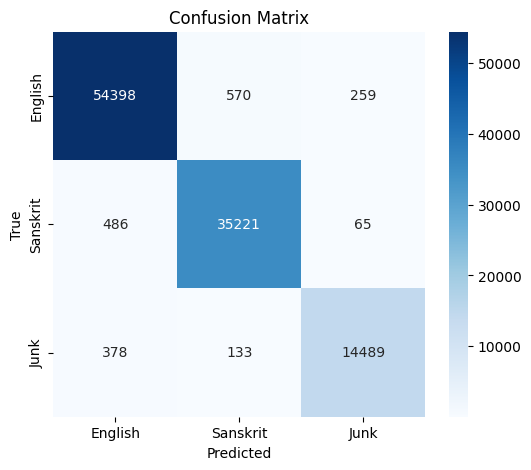

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model on test set
loss, acc = model.evaluate(test_ds)
print(f"\n Test Accuracy: {acc:.4f}")

# Predict on test data
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_map.values()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
best_epoch = np.argmin(history.history["val_loss"]) + 1
best_val_loss = np.min(history.history["val_loss"])
best_val_acc = history.history["val_accuracy"][best_epoch-1]

print(f" Best model saved at epoch {best_epoch} with val_loss={best_val_loss:.4f}, val_accuracy={best_val_acc:.4f}")


🏆 Best model saved at epoch 20 with val_loss=0.0514, val_accuracy=0.9819


In [ ]:
from google.colab import files
files.download("/content/artifacts/best_charcnn_model.keras")
files.download("/content/artifacts/charcnn_pipeline.pkl")
files.download("/content/artifacts/tokenizer.pkl")
files.download("/content/artifacts/label_encoder.pkl")
files.download("/content/artifacts/training_log.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
log_df=pd.read_csv("/content/artifacts/training_log.csv")
log_df.head()

,epoch,accuracy,learning_rate,loss,val_accuracy,val_loss
0,0,0.957696,0.001,0.127882,0.973236,0.079845
1,1,0.970238,0.001,0.085611,0.974811,0.072846
2,2,0.972779,0.001,0.075612,0.976839,0.064370
3,3,0.974661,0.001,0.070141,0.977632,0.061520
4,4,0.975888,0.001,0.066754,0.978981,0.059305


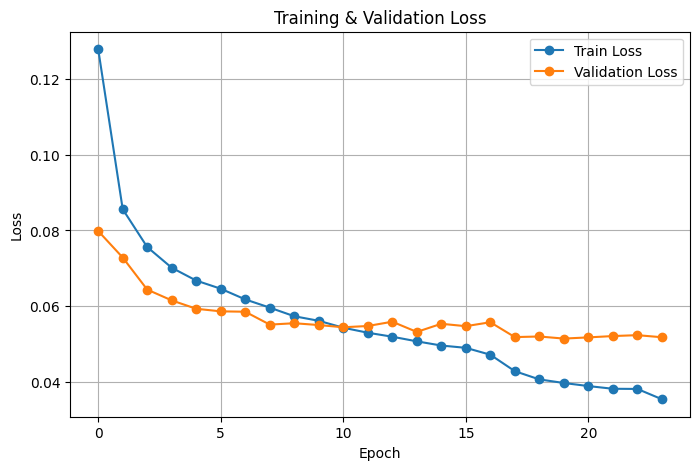

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(log_df['epoch'], log_df['loss'], label='Train Loss', marker='o')
plt.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


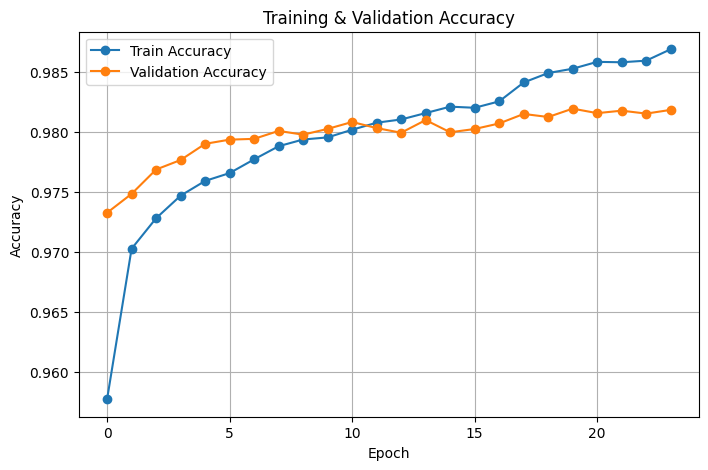

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(log_df['epoch'], log_df['accuracy'], label='Train Accuracy', marker='o')
plt.plot(log_df['epoch'], log_df['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
